In [41]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning modules

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [42]:
# Filter methods

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from functools import partial

In [43]:
# Read ML file
file_path = './data/vax_trials_ml_df.csv'
df_ml = pd.read_csv(file_path)

# Display the DataFrame
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0


#### Feature selection methods

Filter methods

- Variance threshold: to remove any features that have little to no variation in their values.
- Pearson’s correlation: measuring the linear relationship between two numeric, continuous variables. Correlation between features, and correlation between features and target.
- F-statistic: correlation between features and target.
- Mutual information: measures the dependence between two variables and can be used to estimate how much a feature contributes to the prediction of the target variable.

In [44]:
# features
features = df_ml.drop(['nct_id', 'condition_name', 'phase_encoded', 'gender_encoded', 'dropout', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

In [45]:
# Variance threshold
selector = VarianceThreshold(threshold=0)  # 0 is default
print(selector.fit_transform(features))

[[4.500e+02 1.200e+01 1.000e+00 1.082e+03]
 [1.700e+01 6.000e+01 3.000e+00 1.000e+02]
 [7.150e+02 7.000e+00 3.490e+02 1.716e+03]
 ...
 [3.000e+02 7.000e+00 3.000e+00 4.200e+01]
 [1.447e+03 1.200e+01 9.300e+01 5.699e+03]
 [4.800e+01 3.000e+00 6.000e+00 2.480e+02]]


In [46]:
# Use indices to get the corresponding column names of selected features
num_cols = list(features.columns[selector.get_support(indices=True)])
print(num_cols)

['enrollment', 'actual_duration', 'AE_total_serious', 'AE_total_other']


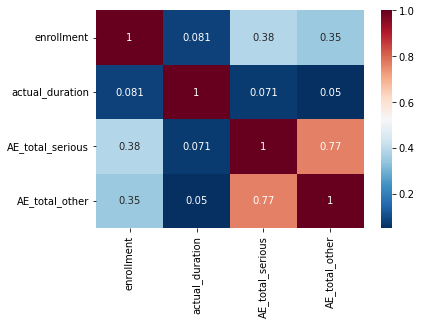

In [47]:
# Pearson’s correlation: 
# Correlation between features: drop highly correlated features to avoid duplicate information.

corr_matrix = features.corr(method='pearson') 

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r')
plt.show()

In [48]:
# Correlation between features and target

X_y = features.copy()
X_y['dropout_rate'] = target

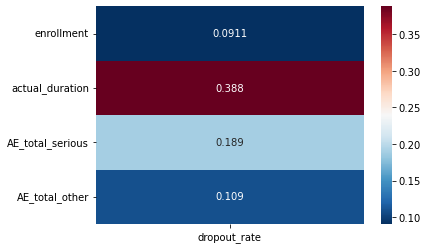

In [49]:
corr_matrix = X_y.corr()

# Isolate the column corresponding to 'dropout'
corr_target = corr_matrix[['dropout_rate']].drop(labels=['dropout_rate'])

sns.heatmap(corr_target, annot=True, fmt='.3', cmap='RdBu_r')
plt.show()

In [50]:
# F-statistic: correlation between features and target
# The F-statistic will be larger (and p-value will be smaller) for predictors that are more highly correlated with the target variable
# First array: F-statistic
# Second array: p-value

print(f_regression(features, target))

(array([  8.4205699 , 178.17908911,  37.39132538,  12.09662295]), array([3.79080586e-03, 1.52927633e-37, 1.38085149e-09, 5.26727886e-04]))


In [51]:
# Mutual information

# features
features = df_ml.drop(['nct_id', 'condition_name', 'dropout', 'dropout_rate'], axis=1)

# target variable
target = df_ml['dropout_rate']

print(mutual_info_regression(features, target, discrete_features=[2,3], random_state=68))

[0.20818195 0.17483381 0.02003992 0.03389111 0.0972512  0.0655195 ]


In [52]:
score_func = partial(mutual_info_regression, discrete_features=[2,3], random_state=68)

# Select top 3 features with the most mutual information
selection = SelectKBest(score_func=score_func, k=3)

print(selection.fit_transform(features, target))

[[4.500e+02 1.200e+01 1.000e+00]
 [1.700e+01 6.000e+01 3.000e+00]
 [7.150e+02 7.000e+00 3.490e+02]
 ...
 [3.000e+02 7.000e+00 3.000e+00]
 [1.447e+03 1.200e+01 9.300e+01]
 [4.800e+01 3.000e+00 6.000e+00]]


In [53]:
X = features[features.columns[selection.get_support(indices=True)]]
print(X)

      enrollment  actual_duration  AE_total_serious
0          450.0             12.0               1.0
1           17.0             60.0               3.0
2          715.0              7.0             349.0
3         2907.0             13.0             119.0
4          668.0             17.0             140.0
...          ...              ...               ...
1004       406.0             19.0               0.0
1005        50.0             56.0              38.0
1006       300.0              7.0               3.0
1007      1447.0             12.0              93.0
1008        48.0              3.0               6.0

[1009 rows x 3 columns]


One-Hot Encoding:

- dummy variables are created to handle categorical variables. They transform each category within a variable into its own binary identifier.
- disadvantage: it can lead to a high-dimensional feature space if there are many unique diseases, so it may not be efficient for large datasets.

In [54]:
# Create dummy variables for 'condition_name' 
df_ml_one_hot = pd.get_dummies(df_ml, columns=['condition_name'], prefix=['condition'])
df_ml_one_hot.head()

,nct_id,enrollment,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other,condition_allergy,condition_autoimmune diseases,condition_cancer,condition_chronic diseases,condition_congenital disorders,condition_heart diseases,condition_infectious diseases,condition_inflammatory diseases,condition_respiratory disorders,condition_transplant
0,NCT00444951,450.0,12.0,6,0,1,3.111111,1.0,1082.0,0,0,0,0,0,0,1,0,0,0
1,NCT00623831,17.0,60.0,2,0,1,11.764706,3.0,100.0,0,0,1,0,0,0,0,0,0,0
2,NCT00434577,715.0,7.0,4,0,1,1.818182,349.0,1716.0,0,0,0,0,0,0,1,0,0,0
3,NCT00616421,2907.0,13.0,6,0,1,3.611971,119.0,4625.0,0,0,0,0,0,0,1,0,0,0
4,NCT04515147,668.0,17.0,4,0,1,8.532934,140.0,3398.0,0,0,0,0,0,0,1,0,0,0


Label Encoding: condititon name.

In [55]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Encode the 'condition_name' column
df_ml['condition_encoded'] = le.fit_transform(df_ml['condition_name'])

# Display the DataFrame with the new column
df_ml.head()

,nct_id,enrollment,condition_name,actual_duration,phase_encoded,gender_encoded,dropout,dropout_rate,AE_total_serious,AE_total_other,condition_encoded
0,NCT00444951,450.0,infectious diseases,12.0,6,0,1,3.111111,1.0,1082.0,6
1,NCT00623831,17.0,cancer,60.0,2,0,1,11.764706,3.0,100.0,2
2,NCT00434577,715.0,infectious diseases,7.0,4,0,1,1.818182,349.0,1716.0,6
3,NCT00616421,2907.0,infectious diseases,13.0,6,0,1,3.611971,119.0,4625.0,6
4,NCT04515147,668.0,infectious diseases,17.0,4,0,1,8.532934,140.0,3398.0,6


#### Select Variables

The data for the model will consist of a subset of variables. The **x** dataframe will contain features that could serve as good predictors for patient dropout in clinical trials. The **y** dataframe will include the target column, denoted by the 'dropout_rate', indicating the percentage of dropouts per clinical trial.

**Table 1.**

target variable: 

- dropout_rate

features:

- enrollment: total number of participants.
- condition_name: the grouped conditions were label encoded.
- actual_duration: total duration.
- phase_encoded: phase categories mapped to numerical values.
- AE_total_serious: total number of serious adverse events.

In [56]:
# Select variables
x = df_ml.drop(['nct_id', 'condition_name', 'gender_encoded', 'dropout', 'dropout_rate', 'AE_total_other' ], axis=1)
y = df_ml['dropout_rate']

#### Splitting the Data

Next, the data needs to be divided into training and validation sets. In this split, 20% of the data is reserved for final validation, while 80% is allocated for training the model.

In [57]:
# Splitting the data

#Validation chunk size
val_size = 0.20

#Split the data into chunks
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=val_size, random_state = 0)

#### Prediction

- **Model Building:** for this project, four algorithms will be used to make predictions:

  1. Linear Regression
  2. K Nearest Neighbor
  3. Decision Trees
  4. Random Forests

- **Evaluation Metrics:**
  - Mean Squared Error (MSE)
  - Mean Absolute Error (MAE)
  - R-squared (R2)

##### Multiple Linear Regression

In [58]:
# Initialize and train a linear regression model
lm = LinearRegression()
lm.fit(x_train, y_train)

# Make predictions on the test set
y_pred = lm.predict(x_test)

In [59]:
# Print coeficients and intercept
print("Coefficients of each feature:", lm.coef_)
print("Intercept:", lm.intercept_)

Coefficients of each feature: [ 1.39035421e-04  1.58710650e-01 -3.59230871e-01  1.28592687e-03
 -2.75195096e+00]
Intercept: 22.20411000365582


In [60]:
#Print train and test score
print("Train score:")
print(lm.score(x_train, y_train))

print("Test score:")
print(lm.score(x_test, y_test))

Train score:
0.22020121591391806
Test score:
0.1998369864993036


In [61]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 218.78960800460985
Root Mean Squared Error: 14.791538392087885
Mean Absolute Error: 8.336305408233711
R-squared: 0.1998369864993036


##### K Nearest Neighbor

In [62]:
# Initialize the KNN regressor 
knn_regressor = KNeighborsRegressor(n_neighbors=5)

# Train the KNN regressor on the training data
knn_regressor.fit(x_train, y_train)

# Make predictions on the test data
y_pred = knn_regressor.predict(x_test)

In [63]:
# Calculate the evaluation metrics to assess the model's performance

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Mean Squared Error: 210.26471585484134
Root Mean Squared Error: 14.500507434391437
Mean Absolute Error: 8.396773536528192
R-squared: 0.23101444257017634


#### Hyperparameter tuning

In [64]:
# Define parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9],   # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2]  # Power parameter for Minkowski metric
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mean Squared Error: 205.91261669613223
Mean Absolute Error: 8.084239413357786
R-squared: 0.2469310521827004


In [65]:
from scipy.stats import randint, uniform
# Define parameter distributions
param_dist = {
    'n_neighbors': randint(1, 10),   # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'p': [1, 2],  # Power parameter for Minkowski metric
}

# Instantiate RandomizedSearchCV
random_search = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit data
random_search.fit(x_train, y_train)

# Access best model and parameters
best_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
Mean Squared Error: 205.91261669613223
Mean Absolute Error: 8.084239413357786
R-squared: 0.2469310521827004


##### Decision Trees

In [66]:
dt = DecisionTreeRegressor(max_depth=3)
dt.fit(x_train, y_train)
y_pred = dt.predict(x_test)
print(dt.score(x_test, y_test))

0.2873772256735144


#### Hyperparameter tuning

In [67]:
# Define parameter grid
param_grid = {
    'max_depth': [None, 3, 5, 10, 15],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit data
grid_search.fit(x_train, y_train)

# Access best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best parameters:", best_params)

# Evaluate on test data
y_pred = best_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

Best parameters: {'max_depth': 3, 'min_samples_split': 10}
Mean Squared Error: 194.85336715068453
Root Mean Squared Error: 13.958988758168857
Mean Absolute Error: 7.875378713903024
R-squared: 0.2873772256735144


In [68]:
# # Plot tree
# plt.figure(figsize=(10,10))
# tree.plot_tree(dt, feature_names = x_train.columns,  
#               filled=True)

##### Random Forests

In [69]:
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
r_squared_train = rfr.score(x_train, y_train)
r_squared_test = rfr.score(x_test, y_test)


# Print `R^2` scores on training and test data
print(f'Train set R^2: {r_squared_train}')
print(f'Test set R^2: {r_squared_test}')

# Print Mean Absolute Error on training and test data
avg_dropout = y.mean()
print(f'Avg dropout rates Train/Test: {avg_dropout}')

y_pred_train = rfr.predict(x_train)
y_pred_test = rfr.predict(x_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
print(f'Train set MAE: {mae_train}')

mae_test = mean_absolute_error(y_test, y_pred_test)
print(f'Test set MAE: {mae_test}')

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (test):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (test):", rmse)

Train set R^2: 0.8706690778915492
Test set R^2: 0.33172779247059836
Avg dropout rates Train/Test: 9.400113587163396
Train set MAE: 3.0803606491955007
Test set MAE: 8.111472885875989
Mean Squared Error (test): 194.85336715068453
Root Mean Squared Error (test): 13.958988758168857


Default Score: 0.33162256277412216
Minimum Test MSE: 171.40329863388195
Best Depth: 6


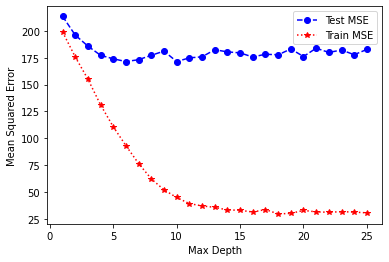

Top 5 Random Forest Features:
             Feature  Importance
1    actual_duration    0.393272
0         enrollment    0.229866
3   AE_total_serious    0.223547
4  condition_encoded    0.079633
2      phase_encoded    0.073682


In [70]:
# Instantiate random forest regressor, fit and score with default parameters
rfr = RandomForestRegressor()
rfr.fit(x_train, y_train)
print("Default Score:", rfr.score(x_test, y_test))

# Tune the hyperparameter max_depth over a range from 1-25, save scores for test and train set
np.random.seed(0)
mse_train = []
mse_test = []

depths = range(1, 26)
for i in depths:
    rfr = RandomForestRegressor(max_depth=i)
    rfr.fit(x_train, y_train)
    y_pred_test = rfr.predict(x_test)
    y_pred_train = rfr.predict(x_train)
    mse_test.append(mean_squared_error(y_test, y_pred_test))
    mse_train.append(mean_squared_error(y_train, y_pred_train))

# Find the best accuracy and at what depth that occurs
print("Minimum Test MSE:", np.min(mse_test))
best_depth = depths[np.argmin(mse_test)]
print("Best Depth:", best_depth)

# Plot the MSE scores for the test and train set over the range of depth values
plt.plot(depths, mse_test, 'bo--', depths, mse_train, 'r*:')
plt.legend(['Test MSE', 'Train MSE'])
plt.xlabel('Max Depth')
plt.ylabel('Mean Squared Error')
plt.show()

# Save the best random forest model and save the feature importances in a dataframe
best_rfr = RandomForestRegressor(max_depth=best_depth)
best_rfr.fit(x_train, y_train)
feature_imp_df = pd.DataFrame(zip(x_train.columns, best_rfr.feature_importances_), columns=['Feature', 'Importance'])
print('Top 5 Random Forest Features:')
print(feature_imp_df.sort_values('Importance', ascending=False).iloc[:5])